<a href="https://colab.research.google.com/github/weeg16/STINTSY/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STINTSY Machine Project**

<font face="Papyrus" size=7 color='#d39aed'>Hi sir alon . 👅<font>

## *Group # - S16*
- **Ang, Danielle Faith**
- **De Los Santos, Hanna Angela**
- **Robles, Luis Miguel**
- **Sarreal, Sophia Althea**

# **Import Libraries**

In [1262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer

# for neural networks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# **Dataset Description**

The file contains data about expenditures and other disbursements, housing characteristics, social protection, Income and other receipts and Entrepreneural Activities.

# **Structure of the Dataset**

# **Reading the Dataset**

In [1263]:
fies_df = pd.read_csv('FIES PUF 2012 Vol.1.CSV')

# **Cleaning the Dataset**

In [1264]:
display(fies_df.head())

,W_REGN,W_OID,W_SHSN,W_HCN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC
0,14,101001000,2,25,2,21100,415052,138.25,200.6576,3.0,...,01,01,,,0.946172,108417.00,9,8,8,9
1,14,101001000,3,43,2,21100,415052,138.25,200.6576,12.5,...,,01,,01,0.946172,30631.60,5,9,9,4
2,14,101001000,4,62,2,21100,415052,138.25,200.6576,2.0,...,,01,,,0.946172,86992.50,9,6,6,8
3,14,101001000,5,79,2,21100,415052,138.25,200.6576,4.0,...,,01,,,0.946172,43325.75,6,6,6,6
4,14,101001000,10,165,2,21100,415052,138.25,200.6576,5.0,...,,,,01,0.946172,37481.80,6,6,6,5


In [1265]:
fies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40171 entries, 0 to 40170
Columns: 119 entries, W_REGN to REGPC
dtypes: float64(5), int64(92), object(22)
memory usage: 36.5+ MB


### ***Drop ID Columns***

In [1266]:
id_cols = ["W_OID", "W_SHSN", "W_HCN"]
fies_df.drop(columns=id_cols, inplace=True, errors='ignore')

### ***Categorical Variables***

In [1267]:
object_columns = fies_df.select_dtypes(include=['object']).columns
print("Categorical Variables (Object Dtypes):")
print(object_columns)

Categorical Variables (Object Dtypes):
Index(['OCCUP', 'KB', 'CW', 'AGELESS5', 'AGE5_17', 'EMPLOYED_PAY',
       'EMPLOYED_PROF', 'DISTANCE', 'RADIO_QTY', 'TV_QTY', 'CD_QTY',
       'STEREO_QTY', 'REF_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY',
       'LANDLINE_QTY', 'CELLPHONE_QTY', 'PC_QTY', 'OVEN_QTY',
       'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY'],
      dtype='object')


By studying the dataset, we see that `AGELESS5`, `AGE5_17`, `EMPLOYED_PAY`,
       `EMPLOYED_PROF`, `DISTANCE`, `RADIO_QTY`, `TV_QTY`, `CD_QTY`,
       `STEREO_QTY`, `REF_QTY`, `WASH_QTY`, `AIRCON_QTY`, `CAR_QTY`,
       `LANDLINE_QTY`, `CELLPHONE_QTY`, `PC_QTY`, `OVEN_QTY`,
       `MOTOR_BANCA_QTY`, `MOTORCYCLE_QTY` all represent numeric quantities.

In [1268]:
cols = ['AGELESS5', 'AGE5_17', 'EMPLOYED_PAY',
       'EMPLOYED_PROF', 'DISTANCE', 'RADIO_QTY', 'TV_QTY', 'CD_QTY',
       'STEREO_QTY', 'REF_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY',
       'LANDLINE_QTY', 'CELLPHONE_QTY', 'PC_QTY', 'OVEN_QTY',
       'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY']

fies_df[cols] = fies_df[cols].apply(pd.to_numeric, errors='coerce')


### ***Mapping/One-Hot Encoding for Categorical Variables***

### **`HGC`** - ***(Household Head) Highest Grade Completed***

The **HGC** variable represents the highest level of education completed by the household head.

### **Education Levels and Codes:**

- **No Grade Completed:** `0`  
- **Preschool:** `10`  
- **Elementary Undergraduate:** `210-260`  
- **Elementary Graduate:** `280`  
- **High School Undergraduate:** `310-330`  
- **High School Graduate:** `350`  
- **Post-Secondary Undergraduate:** `410-420`  
- **Post-Secondary Graduate (Technical/Vocational):** `501-589`  
- **College Undergraduate:** `810-840`  
- **College Graduate:** `601-689`  
- **Post-Baccalaureate:** `900`  

In [1269]:
fies_df["HGC"].unique()

array([280, 250, 552, 830, 350, 634, 554, 320, 514, 240, 581, 810, 614,
       900, 652, 330,   0, 840, 230, 584, 534, 562, 220, 310, 210, 622,
       410, 686, 572, 662, 672, 820, 260, 681, 420, 631, 684, 642, 648,
       601, 646, 676, 586, 589, 658, 689, 501, 621, 548, 632, 654, 638,
       664,  10, 522, 685, 521, 644, 542, 531, 558, 532])

As seen by using **`.unique()`**, these codes are not continuous single values, but instead appear in ranges for certain education levels.

With this, we mapped these numerical codes into standardized categories based on the dictionary.

<small>***Note that the dictionary lists College Undergraduate as ranging from **810-840** and College Graduate as **601-689**, so their values in the mapping may seem reversed.* </small>

In [1270]:
print(fies_df["HGC"].between(601, 689).sum())  # Expected graduates
print(fies_df["HGC"].between(810, 840).sum())  # Expected undergraduates


4210
3237


An ordinal mapping was used to represent educational attainment levels. This ensures that there is a meaningful order.

In [1271]:
conditions = [
    (fies_df["HGC"] == 0),
    (fies_df["HGC"] == 10),
    (fies_df["HGC"].between(210, 260)),
    (fies_df["HGC"] == 280),
    (fies_df["HGC"].between(310, 330)),
    (fies_df["HGC"] == 350),
    (fies_df["HGC"].between(410, 420)),
    (fies_df["HGC"].between(501, 589)),
    (fies_df["HGC"].between(810, 840)),
    (fies_df["HGC"].between(601, 689)),
    (fies_df["HGC"] >= 900)
]

values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fies_df["HGC"] = np.select(conditions, values, default=np.nan)

fies_df["HGC"]

,HGC
0,3.0
1,2.0
2,7.0
3,8.0
4,5.0
...,...
40166,5.0
40167,5.0
40168,2.0
40169,3.0


### **`OCCUP`** - ***Primary occupation of the head of the family during the past six months***

The **OCCUP** variable categorizes the primary occupation of the household head based on standardized occupation codes. These codes are grouped into broader occupational categories.

### **Occupation Groups and Codes:**
- **Officials, Executives, and Managers:** `1110-1490`  
- **Professionals:** `2111-2460`  
- **Technicians and Associate Professionals:** `3111-3480`  
- **Clerks:** `4111-4223`  
- **Service Workers and Sales Workers:** `5111-5230`  
- **Farmers, Forestry Workers, and Fishermen:** `6111-6590`  
- **Trades and Related Workers:** `7111-7442`  
- **Plant and Machine Operators and Assemblers:** `8111-8340`  
- **Laborers and Unskilled Workers:** `9111-9333`  
- **Special Occupations:** `111-113, 121-129, 930`  

In [1272]:
fies_df['OCCUP'].unique()

array(['    ', '1314', '6111', '5220', '6212', '6114', '5132', '7122',
       '9211', '1316', '4121', '1130', '8322', '2331', '3118', '9132',
       '7241', '1312', '7231', '1317', '7123', '4115', '4142', '1120',
       '8324', '8263', '8321', '9131', '9112', '3152', '9133', '6420',
       '1430', '2341', '4215', '6119', '7433', '9313', '1412', '5162',
       '2449', '3450', '6219', '8141', '6112', '6122', '9151', '5169',
       '6116', '6124', '6121', '7243', '7422', '5123', '2310', '1490',
       '3434', '4190', '2412', '6310', '7414', '8275', '3415', '3151',
       '9333', '7212', '9322', '9311', '4113', '2152', '3431', '1319',
       '7141', '1224', '1231', '3131', '4211', '7242', '9120', '6330',
       '5151', '1313', '6340', '7111', '9212', '8222', '5139', '9213',
       '2154', '8231', '9312', '4131', '2224', '9152', '8113', '0129',
       '6129', '5131', '6115', '7415', '0121', '8323', '3232', '5161',
       '3416', '7432', '9161', '3132', '1315', '2221', '9111', '4133',
      

In [1273]:
fies_df['OCCUP'] = fies_df['OCCUP'].apply(pd.to_numeric, errors='coerce')

Like the previous variable, we will map the ranges to represent the categories covered by `OCCUP`. We will do this before applying one-hot encoding because applying one-hot encoding directly to the raw occupation codes would treat each unique value as a separate category, resulting in an unnecessarily large number of features. This would also fail to capture the intended grouping of occupations as defined in the dataset.

In [1274]:
conditions = [
    fies_df["OCCUP"].between(1110, 1490),
    fies_df["OCCUP"].between(2111, 2460),
    fies_df["OCCUP"].between(3111, 3480),
    fies_df["OCCUP"].between(4111, 4223),
    fies_df["OCCUP"].between(5111, 5230),
    fies_df["OCCUP"].between(6111, 6590),
    fies_df["OCCUP"].between(7111, 7442),
    fies_df["OCCUP"].between(8111, 8340),
    fies_df["OCCUP"].between(9111, 9333),
    fies_df["OCCUP"].isin([111, 112, 113, 121, 122, 123, 124, 125, 126, 127, 128, 129, 930])
]

values = [
    "Officials & Executives",
    "Professionals",
    "Technicians",
    "Clerks",
    "Service Workers",
    "Farmers & Fishers",
    "Trades Workers",
    "Machine Operators",
    "Laborers",
    "Special Occupations"
]

fies_df["OCCUP_GROUP"] = np.select(conditions, values, default="Unknown")

fies_df["OCCUP_GROUP"]

,OCCUP_GROUP
0,Unknown
1,Officials & Executives
2,Unknown
3,Farmers & Fishers
4,Service Workers
...,...
40166,Officials & Executives
40167,Machine Operators
40168,Officials & Executives
40169,Officials & Executives


After, one-hot encoding is applied.

In [1275]:
fies_df = pd.get_dummies(fies_df, columns=["OCCUP_GROUP"], drop_first=True, dtype=int)


### **`KB`** - ***Household Head Kind of Business/Industry***

The **KB** variable categorizes the primary business or industry in which the household head is engaged. These industries are grouped based on standardized industry codes.

### **Business/Industry Categories and Codes:**
- **Agriculture, Forestry, and Fishing:** `111-329`  
- **Mining and Quarrying:** `510-990`  
- **Manufacturing:** `1011-3320`  
- **Electricity, Gas, Steam, and Airconditioning Supply:** `3510-3530`  
- **Water Supply, Sewerage, Waste Management, and Remediation Activities:** `3600-3900`  
- **Construction:** `4100-4390`  
- **Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles:** `4510-4799`  
- **Transportation and Storage:** `4911-5320`  
- **Accommodation and Food Service Activities:** `5510-5630`  
- **Information and Communication:** `5811-6399`  
- **Financial and Insurance Activities:** `6411-6630`  
- **Real Estate Activities:** `6811-6820`  
- **Professional, Scientific, and Technical Activities:** `6910-7500`  
- **Administrative and Support Service Activities:** `7710-8299`  
- **Public Administration and Defense; Compulsory Social Security:** `8411-8430`  
- **Education:** `8511-8560`  
- **Human Health and Social Work Services:** `8611-8890`  
- **Arts, Entertainment, and Recreation:** `9000-9329`  
- **Other Service Activities:** `9411-9690`  
- **Activities of Households as Employers of Domestic Personnel:** `9700`  
- **Activities of Extra-Territorial Organizations and Bodies:** `9901-9909`  

In [1276]:
fies_df['KB'] = fies_df['KB'].apply(pd.to_numeric, errors='coerce')

Using the same rationale as the previous variable, mapping the ranges first before one-hot encoding ensures that the business categories are grouped appropriately.

In [1277]:
conditions = [
    fies_df["KB"].between(111, 329),
    fies_df["KB"].between(510, 990),
    fies_df["KB"].between(1011, 3320),
    fies_df["KB"].between(3510, 3530),
    fies_df["KB"].between(3600, 3900),
    fies_df["KB"].between(4100, 4390),
    fies_df["KB"].between(4510, 4799),
    fies_df["KB"].between(4911, 5320),
    fies_df["KB"].between(5510, 5630),
    fies_df["KB"].between(5811, 6399),
    fies_df["KB"].between(6411, 6630),
    fies_df["KB"].between(6811, 6820),
    fies_df["KB"].between(6910, 7500),
    fies_df["KB"].between(7710, 8299),
    fies_df["KB"].between(8411, 8430),
    fies_df["KB"].between(8511, 8560),
    fies_df["KB"].between(8611, 8890),
    fies_df["KB"].between(9000, 9329),
    fies_df["KB"].between(9411, 9690),
    fies_df["KB"] == 9700,
    fies_df["KB"].between(9901, 9909)
]

values = [
    "Agriculture", "Mining", "Manufacturing", "Electricity", "Water Supply", "Construction",
    "Retail", "Transport", "Food Service", "IT", "Finance", "Real Estate", "Professional",
    "Admin", "Public Admin", "Education", "Health", "Arts", "Other Services",
    "Household Employers", "Extra-territorial"
]

fies_df["KB_Group"] = np.select(conditions, values, default=np.nan)

After nominal mapping, we can apply one-hot encoding.

In [1278]:
fies_df = pd.get_dummies(fies_df, columns=["KB_Group"], drop_first=True, dtype=int)

### **`CW`** - ***Household Head Class of Worker***

The **CW_VS1** variable identifies the **class of worker** for the household head during the second visit. It categorizes the employment type based on the nature of the employer or work arrangement.  

### **Categories and Codes:**  
- **Worked for private household**: `0`  
- **Worked for private establishment**: `1`  
- **Worked for government/government corporation**: `2`  
- **Self-employed without any employee**: `3`  
- **Employer in own family-operated farm or business**: `4`  
- **Worked with pay in own family-operated farm or business**: `5`  
- **Worked without pay in own family-operated farm or business**: `6`  

In [1279]:
fies_df['CW'] = fies_df['CW'].apply(pd.to_numeric, errors='coerce')

This is mapped into categorical labels to make the data more interpretable before applying one-hot encoding.

In [1280]:
cw_mapping = {
    0: "Private Household",
    1: "Private Establishment",
    2: "Government",
    3: "Self-Employed",
    4: "Employer in Family Business",
    5: "Worked with Pay in Family Business",
    6: "Worked without Pay in Family Business"
}

fies_df["CW_Group"] = fies_df["CW"].map(cw_mapping)


Apply one-hot encoding.

In [1281]:
fies_df = pd.get_dummies(fies_df, columns=["CW_Group"], drop_first=True, dtype=int)

Check if there are any more `object` dtypes.

In [1282]:
fies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40171 entries, 0 to 40170
Columns: 153 entries, W_REGN to CW_Group_Worked without Pay in Family Business
dtypes: float64(28), int64(125)
memory usage: 46.9 MB


Now, since we converted the dtypes of categorical variables into float/int, we check for missing values.

In [1283]:
missing_values = fies_df.isnull().sum()
print("Missing values per col: ", missing_values[missing_values>0])

Missing values per col:  OCCUP               7374
KB                  7374
CW                  7374
AGELESS5           15361
AGE5_17             8237
EMPLOYED_PAY        8296
EMPLOYED_PROF      12698
DISTANCE           16806
RADIO_QTY          16053
TV_QTY              7812
CD_QTY             14266
STEREO_QTY         23013
REF_QTY            17781
WASH_QTY           20106
AIRCON_QTY         25630
CAR_QTY            26157
LANDLINE_QTY       26133
CELLPHONE_QTY       6425
PC_QTY             23430
OVEN_QTY           24133
MOTOR_BANCA_QTY    27536
MOTORCYCLE_QTY     23128
dtype: int64


We check the percentage of missing data per column.

In [1284]:
missing_percent = (fies_df.isnull().sum() / len(fies_df)) * 100
missing_percent = missing_percent[missing_percent > 0]
print(missing_percent)


OCCUP              18.356526
KB                 18.356526
CW                 18.356526
AGELESS5           38.239028
AGE5_17            20.504842
EMPLOYED_PAY       20.651714
EMPLOYED_PROF      31.609868
DISTANCE           41.836150
RADIO_QTY          39.961664
TV_QTY             19.446865
CD_QTY             35.513181
STEREO_QTY         57.287596
REF_QTY            44.263275
WASH_QTY           50.051032
AIRCON_QTY         63.802245
CAR_QTY            65.114137
LANDLINE_QTY       65.054392
CELLPHONE_QTY      15.994125
PC_QTY             58.325658
OVEN_QTY           60.075676
MOTOR_BANCA_QTY    68.546962
MOTORCYCLE_QTY     57.573872
dtype: float64


For those with missing values `> 80%` , we drop the column.

In [1285]:
missing_threshold = 0.80
missing_percent = fies_df.isnull().mean()

cols_to_drop = missing_percent[missing_percent > missing_threshold].index
fies_df = fies_df.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop.tolist())

Dropped columns: []


In [1286]:
num_imputer = SimpleImputer(strategy="median")
numeric_cols = fies_df.select_dtypes(include=['number']).columns
fies_df[numeric_cols] = num_imputer.fit_transform(fies_df[numeric_cols])

# **Additional Preprocessing**

In [1287]:
numeric_cols = fies_df.select_dtypes(include=['int64', 'float64']).columns

In [1288]:
skewness_values = fies_df[numeric_cols].skew()
print(skewness_values)

W_REGN                                             1.597655
URB                                               -0.482736
RSTR                                              -2.233511
PSU                                                0.019593
BWEIGHT                                            2.159761
                                                    ...    
CW_Group_Private Establishment                     0.763906
CW_Group_Private Household                         7.507205
CW_Group_Self-Employed                             0.679782
CW_Group_Worked with Pay in Family Business       70.843137
CW_Group_Worked without Pay in Family Business    12.507067
Length: 153, dtype: float64


In [1289]:
exclude_cols = [
    "SEX", "JOB",
    "HGC",
    "OCCUP_GROUP", "KB_Group", "CW_Group"
]

exclude_one_hot = [col for col in fies_df.columns if "OCCUP_GROUP_" in col or "KB_Group_" in col or "CW_Group_" in col]

exclude_cols += exclude_one_hot

print("Columns to Exclude from Log Transform & Scaling:", exclude_cols)


Columns to Exclude from Log Transform & Scaling: ['SEX', 'JOB', 'HGC', 'OCCUP_GROUP', 'KB_Group', 'CW_Group', 'OCCUP_GROUP_Farmers & Fishers', 'OCCUP_GROUP_Laborers', 'OCCUP_GROUP_Machine Operators', 'OCCUP_GROUP_Officials & Executives', 'OCCUP_GROUP_Professionals', 'OCCUP_GROUP_Service Workers', 'OCCUP_GROUP_Special Occupations', 'OCCUP_GROUP_Technicians', 'OCCUP_GROUP_Trades Workers', 'OCCUP_GROUP_Unknown', 'KB_Group_Agriculture', 'KB_Group_Arts', 'KB_Group_Construction', 'KB_Group_Education', 'KB_Group_Electricity', 'KB_Group_Extra-territorial', 'KB_Group_Finance', 'KB_Group_Food Service', 'KB_Group_Health', 'KB_Group_Household Employers', 'KB_Group_IT', 'KB_Group_Manufacturing', 'KB_Group_Mining', 'KB_Group_Other Services', 'KB_Group_Professional', 'KB_Group_Public Admin', 'KB_Group_Real Estate', 'KB_Group_Retail', 'KB_Group_Transport', 'KB_Group_Water Supply', 'KB_Group_nan', 'CW_Group_Government', 'CW_Group_Private Establishment', 'CW_Group_Private Household', 'CW_Group_Self-Empl

In [1290]:
skewed_cols = skewness_values[abs(skewness_values) > 1].index
print("Highly skewed variables:", skewed_cols)

Highly skewed variables: Index(['W_REGN', 'RSTR', 'BWEIGHT', 'RFACT', 'AGRI_SAL', 'NONAGRI_SAL',
       'WAGES', 'NETSHARE', 'CASH_ABROAD', 'CASH_DOMESTIC',
       ...
       'KB_Group_Public Admin', 'KB_Group_Real Estate', 'KB_Group_Retail',
       'KB_Group_Transport', 'KB_Group_Water Supply', 'KB_Group_nan',
       'CW_Group_Government', 'CW_Group_Private Household',
       'CW_Group_Worked with Pay in Family Business',
       'CW_Group_Worked without Pay in Family Business'],
      dtype='object', length=129)


In [1291]:
fies_df[skewed_cols] = np.log1p(fies_df[skewed_cols])

numeric_cols = [col for col in fies_df.select_dtypes(include=["int64", "float64"]).columns if col not in exclude_cols]

fies_df[numeric_cols] = np.log1p(fies_df[numeric_cols])



In [1292]:
fies_df[numeric_cols]

,W_REGN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,AGRI_SAL,NONAGRI_SAL,WAGES,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC
0,1.310506,1.098612,2.393985,12.936162,1.781081,1.841592,1.386294,0.00000,0.000000,0.000000,...,0.526589,0.526589,0.0,0.000000,0.665865,2.533201,2.302585,2.197225,2.197225,2.302585
1,1.310506,1.098612,2.393985,12.936162,1.781081,1.841592,2.602690,0.00000,0.000000,0.000000,...,0.000000,0.526589,0.0,0.526589,0.665865,2.427438,1.791759,2.302585,2.302585,1.609438
2,1.310506,1.098612,2.393985,12.936162,1.781081,1.841592,1.098612,0.00000,0.000000,0.000000,...,0.000000,0.526589,0.0,0.000000,0.665865,2.515564,2.302585,1.945910,1.945910,2.197225
3,1.310506,1.098612,2.393985,12.936162,1.781081,1.841592,1.609438,0.00000,0.000000,0.000000,...,0.000000,0.526589,0.0,0.000000,0.665865,2.457580,1.945910,1.945910,1.945910,1.945910
4,1.310506,1.098612,2.393985,12.936162,1.781081,1.841592,1.791759,0.00000,2.431288,2.431288,...,0.000000,0.000000,0.0,0.526589,0.665865,2.445094,1.945910,1.945910,1.945910,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40166,1.271150,0.693147,2.397790,11.644506,1.888087,2.063227,1.791759,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.643360,2.425897,1.791759,1.791759,2.079442,2.079442
40167,1.271150,1.098612,2.397790,12.933785,1.888087,1.998704,2.302585,0.00000,2.470450,2.470450,...,0.000000,0.526589,0.0,0.000000,0.643360,2.358293,0.693147,1.791759,2.079442,1.386294
40168,1.271150,1.098612,2.397790,12.933785,1.888087,1.998704,1.945910,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.643360,2.385036,1.386294,1.609438,1.945910,1.609438
40169,1.271150,1.098612,2.397790,12.933785,1.888087,1.998704,1.791759,0.00000,2.527369,2.527369,...,0.000000,0.526589,0.0,0.000000,0.643360,2.428450,1.791759,1.945910,2.079442,2.079442


# **Feature Selection**

In [1293]:
X = fies_df.drop(columns=["TOINC"])
y = fies_df["TOINC"]

selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Selected Features:\n", selected_features)

Selected Features:
 Index(['T_MILK', 'T_MINERAL', 'T_FOOD_HOME', 'T_FOOD', 'T_FURNISHING',
       'T_HOUSING_WATER', 'T_RENTVAL', 'T_COMMUNICATION', 'T_MISCELLANEOUS',
       'T_NFOOD', 'T_TOTEX', 'T_TOTDIS', 'T_TOREC', 'HGC', 'PC_QTY', 'PCINC',
       'NATPC', 'NATDC', 'REGDC', 'REGPC'],
      dtype='object')


In [1294]:
to_remove = [
    "WAGES", "NETSHARE", "CASH_ABROAD", "CASH_DOMESTIC", "RENTALS_REC",
    "INTEREST", "PENSION", "DIVIDENDS", "OTHER_SOURCE", "NET_RECEIPT",
    "REGFT", "EAINC", "T_IMPUTED_RENT", "T_TOREC", "T_TOTDIS", "T_TOTEX",
    "T_NFOOD", "T_FOOD", "PCINC", "NATPC", "NATDC", "REGDC", "REGPC", "NONAGRI_SAL", "AGRI_SAL"
]

X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

X_selected_df = X_selected_df.drop(columns=to_remove, errors='ignore')

selected_features = [feature for feature in selected_features if feature not in to_remove]

print("Updated Selected Features:\n", selected_features)


Updated Selected Features:
 ['T_MILK', 'T_MINERAL', 'T_FOOD_HOME', 'T_FURNISHING', 'T_HOUSING_WATER', 'T_RENTVAL', 'T_COMMUNICATION', 'T_MISCELLANEOUS', 'HGC', 'PC_QTY']


In [1295]:
X_selected_df = pd.DataFrame(X_selected_df, columns=selected_features)

selected_df = X_selected_df.copy()
selected_df["TOINC"] = y


In [1296]:
selected_df

,T_MILK,T_MINERAL,T_FOOD_HOME,T_FURNISHING,T_HOUSING_WATER,T_RENTVAL,T_COMMUNICATION,T_MISCELLANEOUS,HGC,PC_QTY,TOINC
0,2.215958,2.278017,2.519218,2.217943,2.478002,2.385337,2.115496,2.382588,3.0,0.526589,2.616838
1,2.359048,2.313871,2.571207,2.237250,2.407498,2.186206,2.214308,2.325921,2.0,0.000000,2.628684
2,2.092982,2.186372,2.474923,2.203754,2.451915,2.362350,2.264919,2.325578,7.0,0.000000,2.570069
3,2.232367,2.092173,2.486364,2.395901,2.435865,2.272093,2.177616,2.323606,8.0,0.000000,2.569769
4,2.230896,2.112166,2.493831,2.193079,2.498793,2.476266,2.146070,2.258710,5.0,0.000000,2.575741
...,...,...,...,...,...,...,...,...,...,...,...
40166,2.243861,2.188183,2.502414,2.108469,2.351527,2.306189,2.228320,2.229132,5.0,0.000000,2.558914
40167,2.226785,2.226674,2.539485,2.122400,2.392475,2.319405,2.170006,2.268842,5.0,0.000000,2.547103
40168,2.332489,2.203475,2.528744,2.101980,2.376840,2.313039,2.131458,2.243258,2.0,0.000000,2.537749
40169,2.209222,2.152157,2.532599,2.084931,2.382499,2.313039,2.290712,2.286838,3.0,0.000000,2.561150


# **Exploratory Data Analysis**

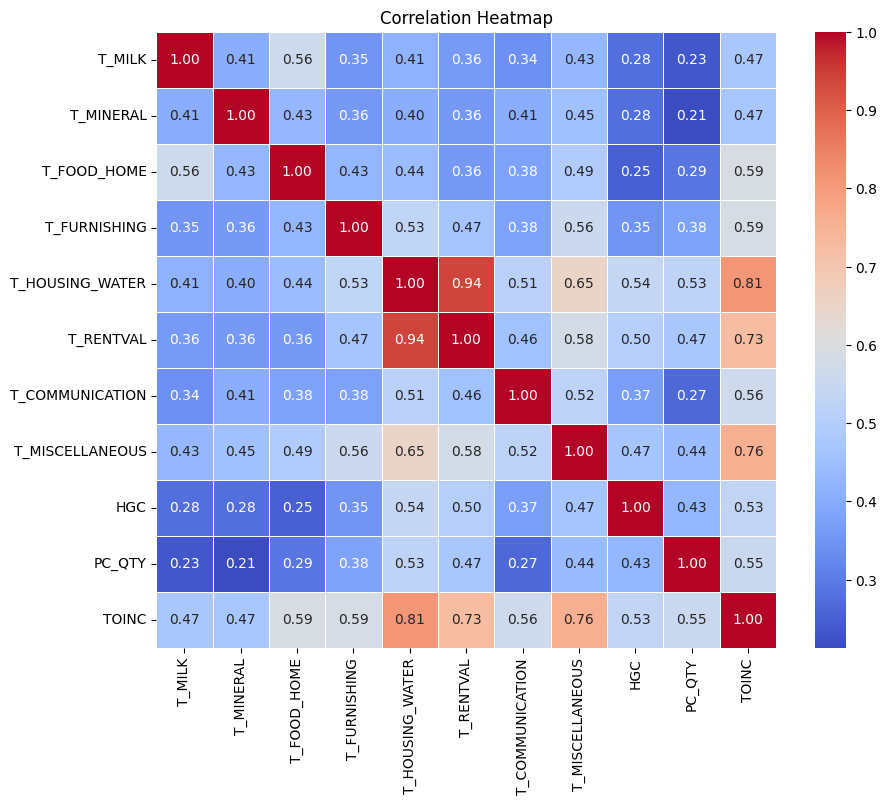

In [1297]:
plt.figure(figsize=(10, 8))
sns.heatmap(selected_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# **Splitting the Dataset**

In [1298]:
X = selected_df.drop(columns=["TOINC"])
y = selected_df["TOINC"]

In [1299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)

In [1300]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-5)

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

Lowering **patience** to ~10 may stop training earlier without hurting performance.

standardize after splitting dataset

In [1301]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

numeric_cols = selected_df.select_dtypes(include=['int64', 'float64']).columns

selected_df[numeric_cols] = scaler.fit_transform(selected_df[numeric_cols])

# **Initial Model Training**

## **K Nearest Neighbors Regression**

In [1302]:
knn = KNeighborsRegressor(n_neighbors=20)

In [1303]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

TEST MSE

In [1304]:
y_pred = knn.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.0007311112332313329


TRAIN MSE

In [1305]:
y_train_pred = knn.predict(X_train)
print(mean_squared_error(y_train, y_train_pred))

0.0006630795133287507


## **Neural Networks**

This section trains a **Neural Network** (**NN**) **for regression** to predict **Total Income** (**TOINC**). The model is designed to handle **non-linear relationship**s in the data and is evaluated to ensure it is **neither overfitting nor underfitting**.

To improve performance, the model consists of **three hidden layers** (128, 64, and 32 neurons) with **ReLU activation**. A **Dropout layer** (**0.2**) is added to prevent overfitting.

In [1306]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),

    Dense(64),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),

    Dense(16),
    BatchNormalization(),
    Activation("relu"),

    Dense(1, activation="linear")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Then we use the **Adam optimizer** with a **lower learning rate** (**0.005**) to improve stability and generalization. The **loss function** is **Mean Squared Error** (**MSE**), and **Mean Absolute Error** (**MAE**) is used to track performance.

In [1307]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

The model is configured to optimize learning with reduced sensitivity to fluctuations.

The model is trained for 50 epochs, avoiding unnecessary computations while maintaining performance. (This might take a while. Batch size = 8 leads to longer training time but more stable results. For faster training, we can try batch size = 16 and compare MAE. )

In [ ]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7351 - mae: 0.5710 - val_loss: 0.0078 - val_mae: 0.0616 - learning_rate: 0.0010
Epoch 2/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0256 - mae: 0.1241 - val_loss: 0.0028 - val_mae: 0.0356 - learning_rate: 0.0010
Epoch 3/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0100 - mae: 0.0781 - val_loss: 0.0018 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 4/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0052 - mae: 0.0561 - val_loss: 0.0012 - val_mae: 0.0266 - learning_rate: 0.0010
Epoch 5/100
 536/2009 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0033 - mae: 0.0444

After training, the model has learned patterns in the training data while monitoring performance on validation data.

The trained model is then tested on unseen data to measure **Mean Absolute Error** (**MAE**) and overall **loss** (**MSE**).

In [ ]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

A low MAE indicates that the model’s predictions are close to actual values. If MAE is too high, further tuning may be needed.

To ensure proper generalization, we **plot the loss curves** for both training and validation data.

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs. Validation Loss (MSE)")
plt.legend()
plt.show()

We then compare the model’s predictions with actual values from the test dataset.

In [ ]:
y_pred = model.predict(X_test_scaled)

results = pd.DataFrame({"Actual": y_test[:5].values, "Predicted": y_pred[:5].flatten()})
print(results)